## Visual Use-case Model Inference 
* the aim of this notebook is to use the final set of trained models to forecast the next 4-hour sequence for a chosen use case.

In [2]:
import os
from io import BytesIO
from pathlib import Path
from typing import Any, Dict, List, Tuple

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xarray as xr
import xskillscore as xs
from livelossplot import PlotLosses
from matplotlib.colors import ListedColormap
from omegaconf import OmegaConf
from PIL import Image
from scipy import io
from torch.nn import L1Loss, MSELoss
from torch.utils.data import DataLoader
from torchmetrics.image import LearnedPerceptualImagePatchSimilarity as LPIPS
from torchmetrics.regression import CriticalSuccessIndex
from tqdm import tqdm

from rainnow.src.conv_lstm_utils import (
    IMERGDataset,
    generate_sequence_conv_lstm,
    plot_predicted_sequence,
    save_checkpoint,
    train,
    validate,
)
from rainnow.src.dyffusion.experiment_types.forecasting_multi_horizon import (
    MultiHorizonForecastingDYffusion,
)
from rainnow.src.dyffusion.experiment_types.interpolation import InterpolationExperiment
from rainnow.src.dyffusion.utilities.evaluation import (
    evaluate_ensemble_crps,
    evaluate_ensemble_spread_skill_ratio,
)
from rainnow.src.loss import CBLoss, LPIPSMSELoss
from rainnow.src.models.conv_lstm import ConvLSTMModel
from rainnow.src.normalise import PreProcess
from rainnow.src.plotting import (
    plot_a_sequence,
    plot_an_interpolated_sequence,
)
from rainnow.src.utilities.instantiators import instantiate_multi_horizon_dyffusion_model
from rainnow.src.utilities.loading import (
    get_model_ckpt_path,
    instantiate_interpolator_model_ckpt_from_config,
    load_imerg_datamodule_from_config,
    load_model_checkpoint_for_eval,
    load_model_state_dict,
)
from rainnow.src.utilities.utils import (
    get_device,
    transform_0_1_to_minus1_1,
    transform_minus1_1_to_0_1,
)

In [3]:
def generate_sequence_dyffusion(
    model: MultiHorizonForecastingDYffusion, inputs: torch.Tensor
) -> Dict[str, torch.Tensor]:
    """
    Generate a sequence using a DYffusion model.

    This function uses the provided DYffusion model to sample a sequence
    based on the given initial condition.

    Parameters
    ----------
    model : MultiHorizonForecastingDYffusion
        The DYffusion model to use for prediction.
    inputs : torch.Tensor
        The input tensor to use as the initial condition for sampling.
    """
    predictions = model.model.sample(initial_condition=inputs)
    if isinstance(model.model_final_layer_activation, nn.Tanh):
        predictions = {k: transform_minus1_1_to_0_1(v) for k, v in predictions.items()}
    return predictions

#### `helpers`

In [4]:
# ** plotting helpers **
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("/teamspace/studios/this_studio/irp-ds423/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 10}

# ** get device **
device = get_device()

No GPU available! (device = cpu)


In [ ]:
# ** DIR helpers **
CKPT_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/results/"
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
# CKPT_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
# CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataloader Params **
BATCH_SIZE = 20  # more than we need just to get entire predict sequence in one batch.
NUM_WORKERS = 0

#### `Instantiate + Load in the datamodule + predict dataloader`

In [ ]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],  # ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)
datamodule.setup("predict")

# set up the dataloaders.
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

[2024-08-28 12:24:33][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-28 12:24:33][imerg_precipitation.py][INFO] --> predict data split: [202303070000, 202303100000]


[2024-08-28 12:27:08][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-08-28 12:27:08][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-28 12:27:08][abstract_datamodule.py][INFO] -->  Dataset predict size: 16


In [6]:
# get a batch of data.
iter_loader = iter(predict_dataloader)
# iter_loader = iter(val_dataloader)
X = next(iter_loader)["dynamics"]

# debug info.
print(f"\n**  batch size = {BATCH_SIZE} **")
print(f"** num batches = {len(iter_loader)} **")
print(f"** num samples = {BATCH_SIZE * len(iter_loader)} ** ")
print(f"** sample dims: {X.shape}")  # (batch_size, sequence_length, channels, H, W)
print(f"** loaded sequence length = {datamodule.hparams.horizon + datamodule.hparams.window} **")


**  batch size = 20 **
** num batches = 1 **
** num samples = 20 ** 
** sample dims: torch.Size([16, 9, 1, 128, 128])
** loaded sequence length = 9 **


#### `Instantiate the preprocessor object`

In [7]:
# ** instantiate the preprocesser obj **
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-28 12:27:08][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [8]:
# store all the models.
models = {}

#### `Load in DYffusion models.`

In [9]:
for ckpt_id, model_key_name in [
    ("dyffusion-daftvdwg", "DYffusion_LCB"),
    ("dyffusion-fyxpjp65", "DYffusion_L1"),
]:
    # ** instantiate a DYffusion model **
    model = instantiate_multi_horizon_dyffusion_model(
        ckpt_id=ckpt_id,
        ckpt_base_path=CKPT_BASE_PATH,
        diffusion_config_overrides={
            "interpolator_checkpoint_base_path": "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
            # "interpolator_checkpoint_base_path": "/Users/ds423/git_uni/irp-ds423/rainnow/results/interpolation_experiments"
        },
    )
    # load in model checkpoint.
    ckpt_path = get_model_ckpt_path(ckpt_id=ckpt_id, ckpt_base_path=CKPT_BASE_PATH, get_last=False)
    print(f"** loading ckpt id from: {ckpt_path} **")
    state_dict = load_model_state_dict(ckpt_path=ckpt_path, device=device)
    model._model.load_state_dict(state_dict)
    # set model into eval mode.
    model.eval()
    model._model.eval()

    # add DYffusion model to the global model store.
    models[model_key_name] = model

[2024-08-28 12:27:08][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 1, 1, 1
[2024-08-28 12:27:08][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 2, 1, 0
[2024-08-28 12:27:08][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-28 12:27:09][dyffusion.py][INFO] --> Successfully loaded (and frozen) interpolator (id: interpolation-cc2yoiyi).
[2024-08-28 12:27:09][_base_experiment.py][INFO] --> Instantiated diffusion model: DYffusion, with #diffusion steps=8
[2024-08-28 12:27:09][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


loading model checkpoint from /teamspace/studios/this_studio/irp-ds423/rainnow/results/interpolation-cc2yoiyi/checkpoints/ImergPrecipitation-interpolation-MH8-BS6-DYffusion_test_epoch028_seed11.ckpt.


[2024-08-28 12:27:09][forecasting_multi_horizon.py][INFO] --> ------------------- Setting num_predictions=1


** loading ckpt id from: /teamspace/studios/this_studio/irp-ds423/rainnow/results/dyffusion-daftvdwg/checkpoints/ImergPrecipitation-dyffusion-MH8-BS6-DYffusion_test_epoch018_seed11.ckpt **


[2024-08-28 12:27:10][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 1, 1, 1
[2024-08-28 12:27:10][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 2, 1, 0
[2024-08-28 12:27:10][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


loading model checkpoint from /teamspace/studios/this_studio/irp-ds423/rainnow/results/interpolation-pmfexw2m/checkpoints/ImergPrecipitation-interpolation-MH8-BS6-DYffusion_test_epoch037_seed11.ckpt.


[2024-08-28 12:27:11][dyffusion.py][INFO] --> Successfully loaded (and frozen) interpolator (id: interpolation-pmfexw2m).
[2024-08-28 12:27:11][_base_experiment.py][INFO] --> Instantiated diffusion model: DYffusion, with #diffusion steps=8
[2024-08-28 12:27:11][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-28 12:27:11][forecasting_multi_horizon.py][INFO] --> ------------------- Setting num_predictions=1


** loading ckpt id from: /teamspace/studios/this_studio/irp-ds423/rainnow/results/dyffusion-fyxpjp65/checkpoints/ImergPrecipitation-dyffusion-MH8-BS6-DYffusion_test_epoch019_seed11.ckpt **


#### `Load in the ConvLSTM Models` 

In [10]:
# ConvLSTM params (make sure that they match up with the model checkpoint).
INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1
IMG_DIMS = (1, 128, 128)

ckpt_params = {
    "convlstm-a8kwo8jx": {
        "input_sequence_length": INPUT_SEQUENCE_LENGTH,
        "output_sequence_length": OUTPUT_SEQUENCE_LENGTH,
        "kernel_size": (5, 5),
        "input_dims": IMG_DIMS,  # C, H, W
        "output_channels": 1,
        "hidden_channels": [128, 128],
        "num_layers": 2,
        "output_activation": nn.Sigmoid(),
    },
    "convlstm-abcd1234": {
        "input_sequence_length": INPUT_SEQUENCE_LENGTH,
        "output_sequence_length": OUTPUT_SEQUENCE_LENGTH,
        "kernel_size": (5, 5),
        "input_dims": IMG_DIMS,  # C, H, W
        "output_channels": 1,
        "hidden_channels": [128, 128],
        "num_layers": 2,
        "output_activation": nn.Tanh(),
    },
}

for ckpt_id, model_key_name in [
    ("convlstm-abcd1234", "ConvLSTM_LCB"),
    ("convlstm-a8kwo8jx", "ConvLSTM_BCE"),
]:
    # get model ckpt path.
    ckpt_id_path = (
        f"/teamspace/studios/this_studio/irp-ds423/rainnow/results/{ckpt_id}/checkpoints/{ckpt_id}.pt"
    )
    print(f"** loading ckpt id from: {ckpt_id_path} **")

    # instantiate a new ConvLSTM model.
    model = ConvLSTMModel(
        input_sequence_length=ckpt_params[ckpt_id]["input_sequence_length"],
        output_sequence_length=ckpt_params[ckpt_id]["output_sequence_length"],
        input_dims=ckpt_params[ckpt_id]["input_dims"],
        hidden_channels=ckpt_params[ckpt_id]["hidden_channels"],
        output_channels=ckpt_params[ckpt_id]["output_channels"],
        num_layers=ckpt_params[ckpt_id]["num_layers"],
        kernel_size=ckpt_params[ckpt_id]["kernel_size"],
        output_activation=ckpt_params[ckpt_id]["output_activation"],
        device=device,
    )
    model = model.to(device)
    # load in the checkpoint + set to eval() mode.
    model.load_state_dict(
        state_dict=torch.load(ckpt_id_path, map_location=torch.device(device))["model_state_dict"]
    )
    model.eval()

    # add ConvLSTM model to the global model store.
    models[model_key_name] = model

** loading ckpt id from: /teamspace/studios/this_studio/irp-ds423/rainnow/results/convlstm-abcd1234/checkpoints/convlstm-abcd1234.pt **


** loading ckpt id from: /teamspace/studios/this_studio/irp-ds423/rainnow/results/convlstm-a8kwo8jx/checkpoints/convlstm-a8kwo8jx.pt **


In [11]:
models.keys()

dict_keys(['DYffusion_LCB', 'DYffusion_L1', 'ConvLSTM_LCB', 'ConvLSTM_BCE'])

#### `Create the prediction inputs`

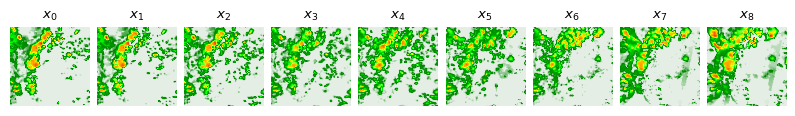

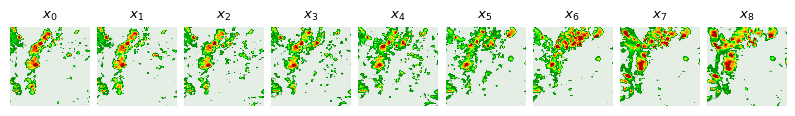

In [12]:
inputs = X.clone()
batch_num = 11
# get x0, interpolated values and xh from X.
x0 = inputs[batch_num, 0, :, :, :]
targets = pprocessor.reverse_processing(inputs)[batch_num, 1:, ...]

# pre-processed sequence.
plot_a_sequence(X, b=batch_num, global_params=global_params, plot_params={"cmap": rain_cmap})
# raw sequence (all preprocessing reversed).
plot_a_sequence(
    pprocessor.reverse_processing(inputs),
    b=batch_num,
    global_params=global_params,
    plot_params=plot_params,
)

In [13]:
# for the ConvLSTM we need to take the last N previous timesteps from batch-1 and attached it to x0.
# so that N+x0 = input_sequence_length.
prev_batch = batch_num - 1
prev_sequence = inputs[batch_num - 1, :, :, :, :]
lookback = INPUT_SEQUENCE_LENGTH - 1
conv_lstm_inputs = torch.cat([prev_sequence[-lookback:, ...], x0.unsqueeze(0)])
assert conv_lstm_inputs.size(0) == INPUT_SEQUENCE_LENGTH

In [14]:
model_inputs = {
    "DYffusion": x0.unsqueeze(0),  # (B, C, H, W)
    "ConvLSTM": conv_lstm_inputs.unsqueeze(0),  # (B, S, N, C, H, W)
}

# checks.
assert model_inputs["DYffusion"].size() == torch.empty(1, 1, 128, 128).size()
assert model_inputs["ConvLSTM"].size() == torch.empty(1, INPUT_SEQUENCE_LENGTH, 1, 128, 128).size()

In [1]:
NUM_ENSEMBLE = 10
model_predictions = {}
for model_name, model in models.items():
    print(f"** generating sequence using {model_name} **")
    if "DYffusion" in model_name:
        # generating ensemble predictions (using DYffusion).
        ens_preds = {}
        for n in range(NUM_ENSEMBLE):
            pred = generate_sequence_dyffusion(
                model=models[model_name], inputs=model_inputs["DYffusion"]
            )
            ens_preds[f"ens_{n+1}"] = pred
        # need to take the mean of the ensemble.
        mean_prediction = torch.mean(
            torch.cat(
                [
                    e.unsqueeze(0)
                    for _, e in {
                        k: torch.cat([q for _, q in v.items()], dim=0) for k, v in ens_preds.items()
                    }.items()
                ],
                dim=0,
            ),
            dim=0,
        )
        model_predictions[model_name] = mean_prediction

    else:
        # generate sequence using ConvLSTM.
        pred = generate_sequence_conv_lstm(
            model=model,
            inputs=model_inputs["ConvLSTM"],
            horizon=8,
            device=device,
        )
        prediction = torch.cat([v for _, v in pred.items()], dim=0)
        model_predictions[model_name] = prediction

#### `plot the results`

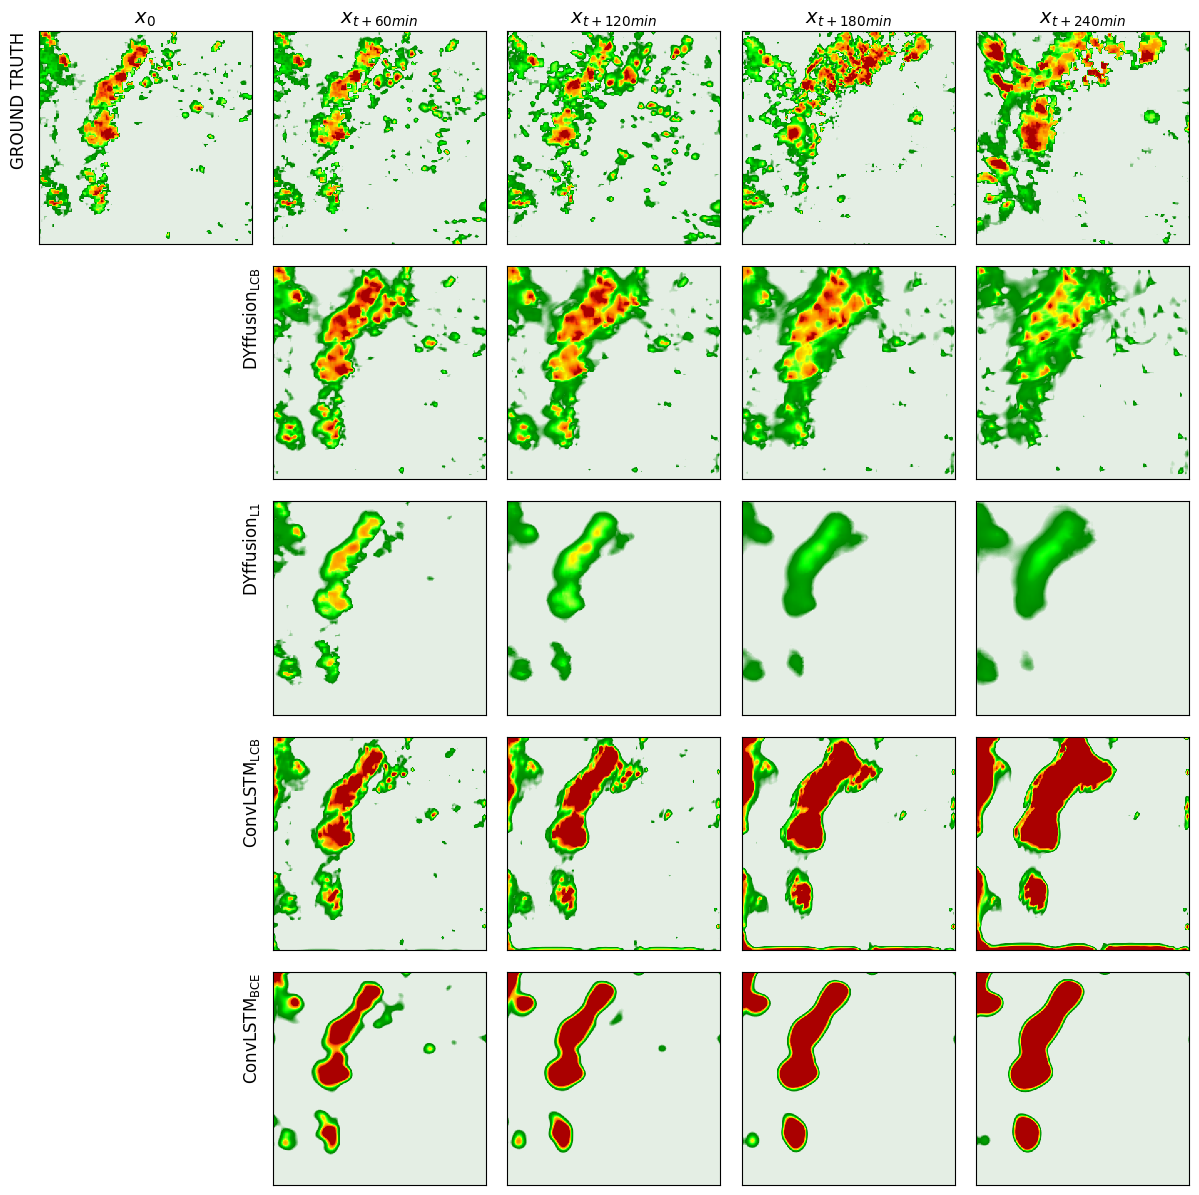

In [18]:
nrows = len(models) + 1
ncols = int(targets.size(0) / 2) + 1
figsize = (12, 12)
fs = 14
dt = 2
c = 0

model_name_formatted = {
    "DYffusion_LCB": r"DYffusion$_{\text{LCB}}$",
    "DYffusion_L1": r"DYffusion$_{\text{L1}}$",
    "ConvLSTM_LCB": r"ConvLSTM$_{\text{LCB}}$",
    "ConvLSTM_BCE": r"ConvLSTM$_{\text{BCE}}$",
}

ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 12}

# reverse x0 back to raw scale.
x0_raw = pprocessor.reverse_processing(x0)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
plt.rcParams.update(global_params)

# plot the targets first.
for i in range(ncols):
    if i == 0:
        # plot x0.
        axs[0, i].imshow(x0_raw[c, ...], **plot_params)
        axs[0, i].set_title(r"$x_0$", fontsize=fs)
    else:
        axs[0, i].imshow(targets[(i * dt) - 1, c, ...], **plot_params)
        num_minutes = i * 60
        axs[0, i].set_title(f"$x_{{t+{num_minutes}min}}$", fontsize=fs)

# plot model predictions.
for j, (model_name, predictions) in enumerate(model_predictions.items()):
    axs[j + 1, 1].set_ylabel(model_name_formatted[model_name], rotation=90, **ylabel_params)
    axs[j + 1, 1].yaxis.set_label_coords(-0.05, 1)
    # get the raw predictions.
    predictions_reversed = pprocessor.reverse_processing(predictions)
    for i in range(1, ncols):
        idx = i * dt - 1
        axs[j + 1, i].imshow(predictions_reversed[idx, c, ...].detach().cpu(), **plot_params)

# remove the box around each subplot.
for j in range(nrows):
    for i in range(ncols):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
for j in range(1, nrows):
    axs[j, 0].spines["top"].set_visible(False)
    axs[j, 0].spines["right"].set_visible(False)
    axs[j, 0].spines["bottom"].set_visible(False)
    axs[j, 0].spines["left"].set_visible(False)

# add labels to the left hand axes.
axs[0, 0].set_ylabel("Ground Truth".upper(), rotation=90, **ylabel_params)
axs[0, 0].yaxis.set_label_coords(-0.05, 1)

plt.tight_layout()
plt.subplots_adjust(**{"wspace": 0.1, "hspace": 0.1})

/tmp/ipykernel_1802/3278726101.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1802/3278726101.py:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


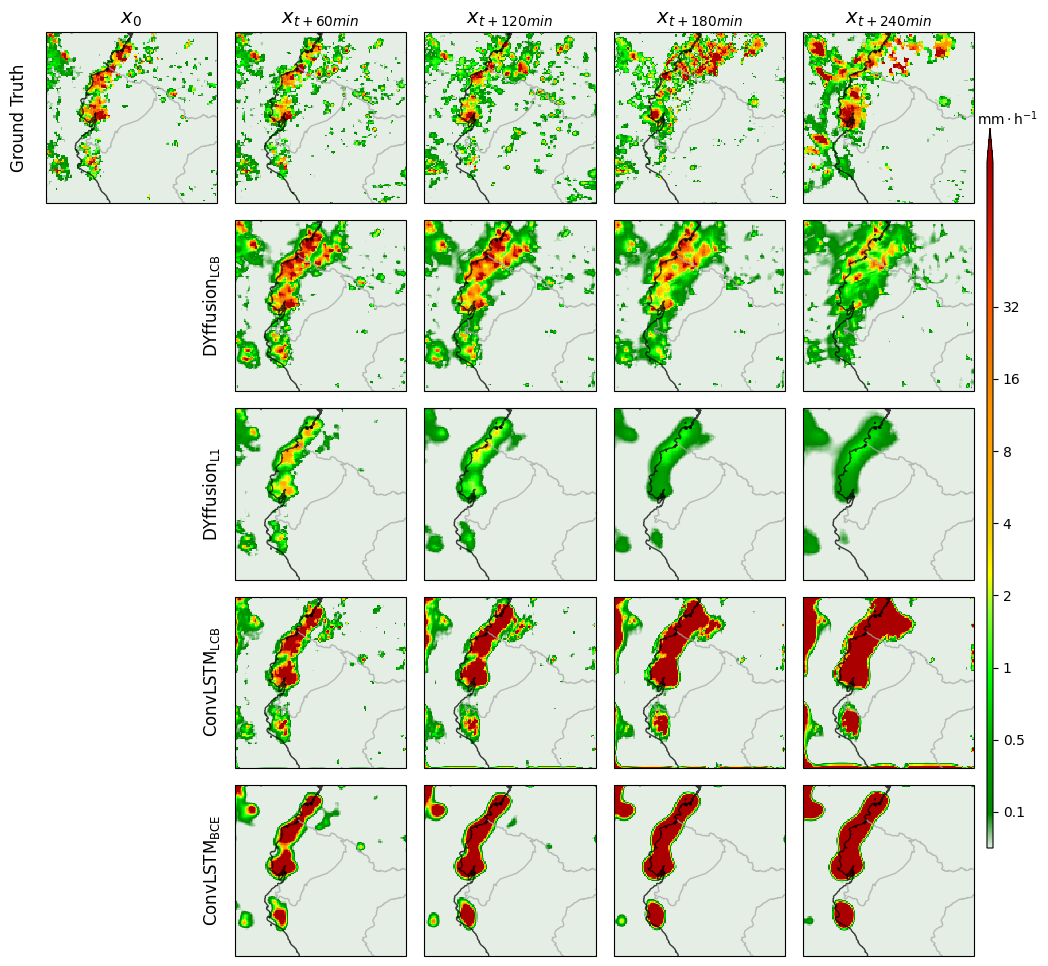

In [46]:
# geo params.
geo_box = [-83.55, -70.75, -8.75, 4.05]  # this is for [1, 0].
lons = np.linspace(-83.55, -70.75, 128)
lats = np.linspace(-8.75, 4.05, 128)
lon_grid, lat_grid = np.meshgrid(lons, lats)

nrows = len(models) + 1
ncols = int(targets.size(0) / 2) + 1
figsize = (12, 12)
fs = 14
dt = 2
c = 0

# labels = ["Ground Truth", "DYffusion_LCB", "DYffusion_L1", "ConvLSTM_LCB", "ConvLSTM_BCE"]
labels = [
    "Ground Truth",
    r"DYffusion$_{\text{LCB}}$",
    r"DYffusion$_{\text{L1}}$",
    r"ConvLSTM$_{\text{LCB}}$",
    r"ConvLSTM$_{\text{BCE}}$",
]
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 12}

# reverse x0 back to raw scale.
x0_raw = pprocessor.reverse_processing(x0)

fig = plt.figure(figsize=figsize)
plt.rcParams.update(global_params)

# keep track of all axes.
gs = gridspec.GridSpec(nrows, ncols + 1, figure=fig, width_ratios=[0.1] + [1] * ncols)
axes = []


def add_geo_ax_to_fig(fig, geo_box, nrows, ncols, index, axes):
    ax = fig.add_subplot(nrows, ncols, index, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.75)
    ax.add_feature(cfeature.BORDERS, edgecolor="darkgrey", linewidth=1, alpha=0.75)
    ax.set_extent(geo_box, crs=ccrs.PlateCarree())
    axes.append(ax)
    return ax


# plot the targets.
for i in range(ncols):
    if i == 0:
        # plot x0.
        ax = add_geo_ax_to_fig(
            fig=fig, geo_box=geo_box, nrows=nrows, ncols=ncols, index=i + 1, axes=axes
        )
        im = ax.pcolormesh(
            lon_grid, lat_grid, np.flipud(x0_raw[c, ...]), transform=ccrs.PlateCarree(), **plot_params
        )
        ax.set_title(r"$x_0$", fontsize=fs)
    else:
        ax = add_geo_ax_to_fig(
            fig=fig, geo_box=geo_box, nrows=nrows, ncols=ncols, index=i + 1, axes=axes
        )
        im = ax.pcolormesh(
            lon_grid,
            lat_grid,
            np.flipud(targets[(i * dt) - 1, c, ...]),
            transform=ccrs.PlateCarree(),
            **plot_params,
        )
        ax.set_title(f"$x_{{t+{i*60}min}}$", fontsize=fs)

# plot model predictions.
for j, (model_name, predictions) in enumerate(model_predictions.items()):
    predictions_reversed = pprocessor.reverse_processing(predictions)
    for i in range(1, ncols):
        ax = add_geo_ax_to_fig(
            fig=fig,
            geo_box=geo_box,
            nrows=nrows,
            ncols=ncols,
            index=((j + 1) * ncols) + i + 1,
            axes=axes,
        )
        im = ax.pcolormesh(
            lon_grid,
            lat_grid,
            np.flipud(predictions_reversed[(i * dt - 1), c, ...].detach().cpu()),
            transform=ccrs.PlateCarree(),
            **plot_params,
        )

for i, label in enumerate(labels):
    label_ax = fig.add_subplot(gs[i, 0])
    label_ax.axis("off")
    xx, yy = -1.01, 0.5
    if i > 0:
        xx = 10.5
    label_ax.text(xx, yy, label, rotation=90, va="center", ha="right", fontsize=12)

# Add single colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.91, 0.2, 0.005, 0.6])
cbar = plt.colorbar(im, cax=cbar_ax, **{"extend": "max", "pad": 0.05})
cbar.set_ticks(np.arange(1, 9, 1))
cbar.set_ticklabels(["0.1", "0.5", "1", "2", "4", "8", "16", "32"], fontsize=10)
cbar.ax.text(
    3.5,
    1.05,
    r"$\text{mm}\cdot\text{h}^{-1}$",
    transform=cbar.ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=10,
)

plt.tight_layout()
plt.subplots_adjust(**{"wspace": 0.1, "hspace": 0.1, "right": 0.9})

#### `Prediction GIFs`

In [ ]:
# frames per second.
fs = 20

# plot model predictions.
gifs = {}
for j, (model_name, predictions) in enumerate(model_predictions.items()):
    predictions_reversed = pprocessor.reverse_processing(predictions)
    num_sequence = predictions_reversed.size(0)
    frames = []
    for i in range(num_sequence):
        # set up a new figure each time.
        fig = plt.figure(figsize=(6, 6), dpi=100)
        ax = fig.add_subplot(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.75)
        ax.add_feature(cfeature.BORDERS, edgecolor="darkgrey", linewidth=1, alpha=0.75)
        ax.set_extent(geo_box, crs=ccrs.PlateCarree())
        ax.pcolormesh(lon_grid, lat_grid, np.flipud(predictions_reversed[i, c, ...].detach().cpu()), transform=ccrs.PlateCarree(), **plot_params)
        ax.set_title(f"$x_{{t+{i*60}min}}$", fontsize=fs)

        # Save the figure correctly
        fig.canvas.draw()
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=100)
        buf.seek(0)
        image = Image.open(buf)
        image = image.convert("RGBA")
        frames.append(np.array(image))
        plt.close(fig)
        buf.close()

    print(len(frames))
    gif_path = f"{model_name}_prediction.gif"
    imageio.mimsave(gif_path, frames, fps=2)

    gifs[model_name] = frames

# also get GIF for targets.
frames = []
for i in range(num_sequence):
    # set up a new figure each time.
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.75)
    ax.add_feature(cfeature.BORDERS, edgecolor="darkgrey", linewidth=1, alpha=0.75)
    ax.set_extent(geo_box, crs=ccrs.PlateCarree())
    ax.pcolormesh(lon_grid, lat_grid, np.flipud(targets[i, c, ...].detach().cpu()), transform=ccrs.PlateCarree(), **plot_params)
    ax.set_title(f"$x_{{t+{i*60}min}}$", fontsize=fs)

    # Save the figure correctly
    fig.canvas.draw()
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    buf.seek(0)
    image = Image.open(buf)
    image = image.convert("RGBA")
    frames.append(np.array(image))
    plt.close(fig)
    buf.close()

print(len(frames))
gif_path = f"targets_prediction.gif"
imageio.mimsave(gif_path, frames, fps=2)

### END OF SCRIPT.